In [1]:
from setup_env import setup_environment

setup_environment()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
file = "20260124_163324.csv"
df = pd.read_csv(f"data/training/judge/{file}")

df.sample(3)

,entropy_mean,entropy_std,entropy_max,entropy_min,entropy_premax,n_cells,p_collapsed,p_uncollapsed,p_walkable_collapsed,p_entropy_1,p_entropy_2,p_entropy_3,entropy_gradient_mean,entropy_gradient_max,should_continue
14487,12.848889,12.551558,27.0,0.0,27.0,225.0,0.391111,0.604444,0.284091,0.004444,0.0,0.031111,2.469048,24.0,1
7314,9.408889,11.785939,27.0,0.0,27.0,225.0,0.511111,0.488889,0.243478,0.000000,0.0,0.035556,2.392857,23.0,1
1447,11.426667,12.377945,27.0,0.0,27.0,225.0,0.435556,0.555556,0.520408,0.008889,0.0,0.040000,2.726190,26.0,1


In [5]:
X = df.drop(columns=['should_continue'])
y = df['should_continue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', # <--- THIS HANDLES YOUR IMBALANCE!
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0      0.738     0.230     0.350       196
           1      0.975     0.997     0.986      5807

    accuracy                          0.972      6003
   macro avg      0.856     0.613     0.668      6003
weighted avg      0.967     0.972     0.965      6003

Confusion matrix:
 [[  45  151]
 [  16 5791]]


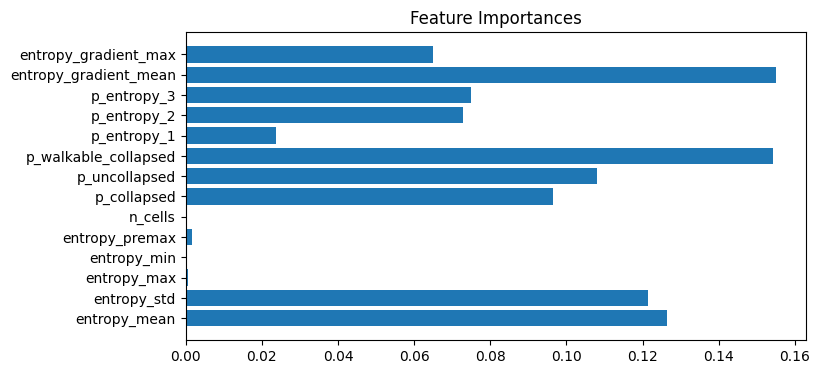

In [8]:
import matplotlib.pyplot as plt
importances = clf.feature_importances_
feat_names = X.columns
plt.figure(figsize=(8,4))
plt.barh(feat_names, importances)
plt.title('Feature Importances')
plt.show()
